In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
#from keras.applications.inception_v3 import preprocess_input
#from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import image
from keras.preprocessing import sequence
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
from numpy import array
from pickle import load
from PIL import Image
from collections import Counter

import tensorflow as tf
import keras
import re
import pandas as pd
import string
import string
import numpy as np
import pandas as pd
import simplejson as json
import pickle
import matplotlib.pyplot as plt
import glob
import sys
import time
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWhwPYrAGvCun6PxOcKuzuwWsahg3zVXNL4bt86zu2pE1e0j7a9KKbM


ValueError: ignored

# Load the captions

In [ ]:
filePath = 'annotations/'

In [ ]:
data = json.load(open(filePath + 'train.json', 'r'))
dataset = {}
for key, value in data.items():
    if key != 'annotations':
        dataset[key] = value
dataset['annotations'] = []
for annotation in data['annotations']:
    dataset['annotations'].append(annotation)

In [ ]:
image_id = set()
captions = list()
for annotation in dataset['annotations']:
    image_id.add(annotation['image_id'])
    captions.append(annotation['caption'])

In [ ]:
df_annotations = pd.json_normalize(dataset, record_path=['annotations'])

In [ ]:
df_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117155 entries, 0 to 117154
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   caption        117155 non-null  object
 1   image_id       117155 non-null  int64 
 2   is_precanned   117155 non-null  bool  
 3   is_rejected    117155 non-null  bool  
 4   id             117155 non-null  int64 
 5   text_detected  117155 non-null  bool  
dtypes: bool(3), int64(2), object(1)
memory usage: 3.0+ MB


## Filter precanned and rejected captions

In [ ]:
new_df = df_annotations[df_annotations['is_precanned'] == False]

In [ ]:
new_df = new_df[new_df['is_rejected'] == False]

In [ ]:
i = 1050

while i > 1000:
    tmp_df = new_df[new_df['image_id'] < i] 
    if len(tmp_df['image_id'].unique()) < 1002:
        print(i)
        break
    
    i -= 1

1017


In [ ]:
new_df = new_df[new_df['image_id'] < i]

In [ ]:
len(new_df['image_id'].unique())

1001

only consider the captions for 1001 images

In [ ]:
#df_annotations = df_annotations[0:5005]
df_annotations = new_df.reset_index(drop=True)

In [ ]:
df_annotations

,caption,image_id,is_precanned,is_rejected,id,text_detected
0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,0,False,False,0,True
1,A green and white plastic condiment bottle con...,0,False,False,1,True
2,A bottle of spices in a plastic container layi...,0,False,False,3,True
3,some basil leaves in a container on a counter,0,False,False,4,True
4,A can of Coca Cola on a counter is shown for w...,1,False,False,5,True
...,...,...,...,...,...,...
4362,Hand holding a package of Betty Crocker brand ...,1015,False,False,5079,True
4363,a person holding a blue can of food to the camera,1016,False,False,5081,True
4364,A person holds a tin can of food in their hand...,1016,False,False,5082,True
4365,Someone holding a can of food near a kitchen c...,1016,False,False,5083,True


## operation to convert the image_id to the name stored in the dataset.

In [ ]:
for i in range(0, len(df_annotations)):
    number_str = str(df_annotations["image_id"][i])
    df_annotations["image_id"][i] = 'VizWiz_train_' + number_str.zfill(8)
    if(i < 15):
        print(df_annotations["image_id"][i])

VizWiz_train_00000000
VizWiz_train_00000000
VizWiz_train_00000000
VizWiz_train_00000000
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000003


## make a dictionary to store image_id and corresponding captions

In [ ]:
df_annotations

,caption,image_id,is_precanned,is_rejected,id,text_detected
0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,VizWiz_train_00000000,False,False,0,True
1,A green and white plastic condiment bottle con...,VizWiz_train_00000000,False,False,1,True
2,A bottle of spices in a plastic container layi...,VizWiz_train_00000000,False,False,3,True
3,some basil leaves in a container on a counter,VizWiz_train_00000000,False,False,4,True
4,A can of Coca Cola on a counter is shown for w...,VizWiz_train_00000001,False,False,5,True
...,...,...,...,...,...,...
4362,Hand holding a package of Betty Crocker brand ...,VizWiz_train_00001015,False,False,5079,True
4363,a person holding a blue can of food to the camera,VizWiz_train_00001016,False,False,5081,True
4364,A person holds a tin can of food in their hand...,VizWiz_train_00001016,False,False,5082,True
4365,Someone holding a can of food near a kitchen c...,VizWiz_train_00001016,False,False,5083,True


In [ ]:
descriptions = {}

for item in df_annotations.to_numpy():
    
    caption = item[0]
    tokens = caption
    image_id = item[1]
    
    if image_id not in descriptions:
        descriptions[image_id] = list()
    descriptions[image_id].append(tokens)

## Text Processing utilities

In [ ]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)


def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)


def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)


def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

## Clean the captions reside in descriptions dict

In [ ]:
table = str.maketrans('', '', string.punctuation)
for image_id, captions in descriptions.items():
    for i in range(len(captions)):
        desc = captions[i].split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        captions[i] = ' '.join(desc)

In [ ]:
descriptions["VizWiz_train_00000000"]

['its is a basil leaves container its contains the net weight too',
 'a green and white plastic condiment bottle containing basil leaves',
 'a bottle of spices in a plastic container laying on a surface',
 'some basil leaves in a container on a counter']

## Visualize the image with captions

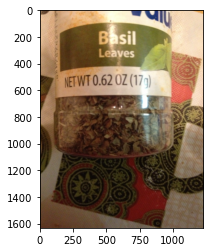

['its is a basil leaves container its contains the net weight too',
 'a green and white plastic condiment bottle containing basil leaves',
 'a bottle of spices in a plastic container laying on a surface',
 'some basil leaves in a container on a counter']

In [ ]:
images_path = "dataset/train/"
pic = 'VizWiz_train_00000000.jpg'
x = plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['VizWiz_train_00000000']

## Total vocabulary size

In [ ]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 4052


## Create list of image path

In [ ]:
img = glob.glob(images_path + '*.jpg')

In [ ]:
img[i].split('/')[-1]

'VizWiz_train_00000705.jpg'

In [ ]:
train_images = list()
for key in descriptions.keys():
    train_images.append(key + ".jpg")

In [ ]:
train_img = []
for i in img:
    image_name = i.split('/')[-1]
    if image_name in train_images:
        train_img.append(i)

In [ ]:
len(train_img)

1001

## Create train description dict with captions starting with startseq and ends with endsq

In [ ]:
for image_id, captions in descriptions.items():
    for i in range(len(captions)):
        desc = 'startseq ' + captions[i] + ' endseq'
        descriptions[image_id][i] = desc

In [ ]:
#for image_id , captions in descriptions.items():
#    for i in range(len(captions)):
#      desc = 'startseq ' + ' '.join(captions[i]) + ' endseq'
#      descriptions[image_id][i] = desc

In [ ]:
descriptions['VizWiz_train_00000000']

['startseq its is a basil leaves container its contains the net weight too endseq',
 'startseq a green and white plastic condiment bottle containing basil leaves endseq',
 'startseq a bottle of spices in a plastic container laying on a surface endseq',
 'startseq some basil leaves in a container on a counter endseq']

## List of all captions

In [ ]:
all_train_captions = []
for key, val in descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [ ]:
len(all_train_captions)

4367

## Reduce the vocabulary size

In [ ]:
word_count_threshold = 2
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 2401


## Create word embedding

In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [ ]:
all_desc = list()
for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 56


## Glove embedding

In [ ]:
embeddings_index = {}
f = open(os.path.join('glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
f.close()

## Create embedding matrix

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
items = wordtoix.items()
for word, i in items:
    if i % 10 == 0:
        print("%d/%d" % (i, vocab_size-1), end='\r')
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(2402, 200)

# Model building

In [ ]:
model = VGG16(include_top=True, weights='imagenet')

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Select the layer before the densly connected layers.

In [ ]:
model_new = Model(model.input, model.layers[-2].output)
model_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
ENCODER_OUTPUT_DIM = model_new.output_shape[1]
ENCODER_INPUT_DIM = (model_new.input_shape[1],model_new.input_shape[2])

In [ ]:
model_new.save('models/vgg16-encoder.h5')

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=ENCODER_INPUT_DIM)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    # Some models have a defined preprocess_input
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [ ]:
encoding_train = {}
num = 0
for img in train_img:
    num += 1
    if(num % 10 == 0):
        print("Encoding: %d" %(num),end='\r')
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

In [ ]:
train_features['VizWiz_train_00000000.jpg'].shape

(4096,)

In [ ]:
# Feature Vectors for images
inputs1 = Input(shape=(ENCODER_OUTPUT_DIM,))  # Shape of Feature vector
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Captions
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(128, return_sequences=True))(se2)
se4 = Bidirectional(LSTM(128))(se3)

decoder1 = add([fe2, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 56)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 56, 200)      480400      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 56, 200)      0           embedding[0][0]                  
____________________________________________________________________________________________

## Transfer learning

In [ ]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 56)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 56, 200)      480400      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 56, 200)      0           embedding[0][0]                  
____________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Train the model in batches

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n += 1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word]
                       for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs

                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical(
                        [out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
model = tf.keras.models.load_model('models/vgg16-4096-bidirectional.h5')

In [ ]:
chkpt = tf.keras.callbacks.ModelCheckpoint('models/vgg16-4096-bidirectional.h5', verbose=1)

In [ ]:
epochs = 30
batch_size = 3
steps = len(descriptions)//batch_size

generator = data_generator(descriptions, 
                           train_features, 
                           wordtoix, 
                           max_length, 
                           batch_size)

model.fit(generator, 
          epochs=epochs, 
          steps_per_epoch=steps, 
          verbose=1,
          callbacks=[chkpt]
         )

Epoch 1/30
333/333 [==============================] - 119s 357ms/step - loss: 1.3798

Epoch 00001: saving model to models/vgg16-4096-bidirectional.h5
Epoch 2/30
333/333 [==============================] - 124s 372ms/step - loss: 1.3499

Epoch 00002: saving model to models/vgg16-4096-bidirectional.h5
Epoch 3/30
333/333 [==============================] - 121s 363ms/step - loss: 1.3256

Epoch 00003: saving model to models/vgg16-4096-bidirectional.h5
Epoch 4/30
333/333 [==============================] - 120s 360ms/step - loss: 1.2954

Epoch 00004: saving model to models/vgg16-4096-bidirectional.h5
Epoch 5/30
333/333 [==============================] - 125s 376ms/step - loss: 1.2832

Epoch 00005: saving model to models/vgg16-4096-bidirectional.h5
Epoch 6/30
333/333 [==============================] - 122s 367ms/step - loss: 1.2660

Epoch 00006: saving model to models/vgg16-4096-bidirectional.h5
Epoch 7/30
333/333 [==============================] - 131s 392ms/step - loss: 1.2505

Epoch 00007: s

In [ ]:
model.save('models/vgg16-4096-bidirectional.h5')

# Greedy and beam search

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index=3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences(
                [s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image, par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

# Evaluation

In [ ]:
def evaluate_image(image_path):
    pic = image_path + '.jpg'
    image = encoding_train[pic].reshape((1, ENCODER_OUTPUT_DIM))
    x = plt.imread(images_path+pic)
    plt.imshow(x)
    plt.show()
    
    print("Ground Truth")
    print([' '.join(sen.split()[1:-1]) for sen in descriptions[image_path]])
    
    print()
    print("Greedy Search:", greedySearch(image))
    print("Beam Search, K = 3:", beam_search_predictions(image, beam_index=3))
    print("Beam Search, K = 5:", beam_search_predictions(image, beam_index=5))
    print("Beam Search, K = 7:", beam_search_predictions(image, beam_index=7))
    #print("Beam Search, K = 10:", beam_search_predictions(image, beam_index=10))

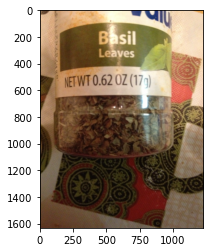

Ground Truth
['its is a basil leaves container its contains the net weight too', 'a green and white plastic condiment bottle containing basil leaves', 'a bottle of spices in a plastic container laying on a surface', 'some basil leaves in a container on a counter']

Greedy Search: a container of spices on a counter pie carpet
Beam Search, K = 3: a container of spices in its packaging
Beam Search, K = 5: a container of spices laying on a counter
Beam Search, K = 7: picture of a bottle of spices on a counter


In [ ]:
evaluate_image('VizWiz_train_00000000')

# Validation Data

Validation data are images 2000 to 20001 in the training set. This section of code preprocess validation captions in the same way as before.

In [ ]:
val_data = json.load(open(filePath + 'train.json', 'r'))
val_dataset = {}

for key, value in val_data.items():
    if key != 'annotations':
        val_dataset[key] = value
val_dataset['annotations'] = []

for annotation in val_data['annotations']:
    val_dataset['annotations'].append(annotation)
    
image_id = set()
captions = list()
for annotation in val_dataset['annotations']:
    image_id.add(annotation['image_id'])
    captions.append(annotation['caption'])

df_validation = pd.json_normalize(val_dataset, record_path=['annotations'])

In [ ]:
df_validation = df_validation[df_validation["is_precanned"] == False]
df_validation = df_validation[df_validation["is_rejected"] == False]
df_validation = df_validation[df_validation["image_id"] > 1999]

In [ ]:
# This block of codes finds the highest image_id so there are still 
# 100 validation images
# This is necessary, because filtering precanned and rejected captions
# may delete some photos.

i = 2150

while i > 1999:
    df_validation = df_validation[df_validation["image_id"] < i]
    
    if len(df_validation['image_id'].unique()) <= 100:
        print(i)
        break
    
    i -= 1

2102


In [ ]:
df_validation = df_validation.reset_index(drop=True)

In [ ]:
df_validation

,caption,image_id,is_precanned,is_rejected,id,text_detected
0,"Desk with a computer monitor on it, in the for...",2000,False,False,10000,True
1,A white bottle of hair conditioner rests on th...,2000,False,False,10001,True
2,A white bottle of Salon hair conditioner in fr...,2000,False,False,10002,True
3,A mac computer screen with a bottle covering p...,2000,False,False,10003,False
4,The computer screen is large and shows a scree...,2000,False,False,10004,True
...,...,...,...,...,...,...
436,A white and yellow rectangular box of filters ...,2100,False,False,10504,True
437,Two tubes of hand cream on a carpet.,2101,False,False,10505,True
438,a small sample size product laying on the floor,2101,False,False,10506,False
439,a small white tube of cream sitting on a rug w...,2101,False,False,10508,True


In [ ]:
for i in range(0, len(df_validation)):
    number_str = str(df_validation["image_id"][i])
    df_validation["image_id"][i] = 'VizWiz_train_' + number_str.zfill(8)
    if(i < 15):
        print(df_validation["image_id"][i])

VizWiz_train_00002000
VizWiz_train_00002000
VizWiz_train_00002000
VizWiz_train_00002000
VizWiz_train_00002000
VizWiz_train_00002001
VizWiz_train_00002001
VizWiz_train_00002001
VizWiz_train_00002001
VizWiz_train_00002002
VizWiz_train_00002002
VizWiz_train_00002002
VizWiz_train_00002002
VizWiz_train_00002002
VizWiz_train_00002003


## Create Dictionary of Image IDs to Captions

In [ ]:
val_descriptions = {}

for item in df_validation.to_numpy():
    
    caption = item[0]
    tokens = caption
    image_id = item[1]
    
    if image_id not in val_descriptions:
        val_descriptions[image_id] = list()
    val_descriptions[image_id].append(tokens)

In [ ]:
table = str.maketrans('', '', string.punctuation)
for image_id, captions in val_descriptions.items():
    for i in range(len(captions)):
        desc = captions[i].split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        captions[i] = ' '.join(desc)

In [ ]:
val_descriptions["VizWiz_train_00002000"]

['desk with a computer monitor on it in the foreground is a bottle of salon conditioner',
 'a white bottle of hair conditioner rests on the desk in front of a computer',
 'a white bottle of salon hair conditioner in front of a computer monitor',
 'a mac computer screen with a bottle covering part of the screen in the image',
 'the computer screen is large and shows a screen full of text']

## Generate Captions and Calculate Bleu Scores

In [ ]:
def encode_test(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=ENCODER_INPUT_DIM)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    fea_vec = model_new.predict(img)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [ ]:
num = 0
total_bleu_score = [0, 0, 0, 0]

results = {}
total_num = len(val_descriptions)

max_bleu = [0, 0, 0, 0]
max_bleus_1 = {}
max_bleus_2 = {}
max_bleus_3 = {}
max_bleus_4 = {}

for key, ground_truth in val_descriptions.items():

    references = [sen.split() for sen in ground_truth]
    pic = key + ".jpg"
    
    # Load and Encode Image
    image = encode_test("dataset/validation/" + pic).reshape((1, ENCODER_OUTPUT_DIM))
    
    captions = []
    
    print("Beam search... k=3  %d/%d" % (num, total_num), end='\r')  
    captions.append(beam_search_predictions(image,3).split())
    
    results[key] = [' '.join(caption) for caption in captions]
    

    total_bleu_score[0] += 100 * sentence_bleu(references, captions[0], weights=(1,0,0,0)) 
    total_bleu_score[1] += 100 * sentence_bleu(references, captions[0], weights=(0.5,0.5,0,0)) 
    total_bleu_score[2] += 100 * sentence_bleu(references, captions[0], weights=(0.33,0.33,0.33,0)) 
    total_bleu_score[3] += 100 * sentence_bleu(references, captions[0], weights=(0.25,0.25,0.25,0.25))    
        
    bleu_1 = 100 * sentence_bleu(references, captions[0], weights=(1,0,0,0)) 
    bleu_2 = 100 * sentence_bleu(references, captions[0], weights=(0.5,0.5,0,0)) 
    bleu_3 = 100 * sentence_bleu(references, captions[0], weights=(0.33,0.33,0.33,0)) 
    bleu_4 = 100 * sentence_bleu(references, captions[0], weights=(0.25,0.25,0.25,0.25))    
    
    if bleu_1 >= max_bleu[0]:
        max_bleu[0] = bleu_1
        max_bleus_1[pic] = (results[key], bleu_1)
    
    if bleu_2 >= max_bleu[1]:
        max_bleu[1] = bleu_2
        max_bleus_2[pic] = (results[key], bleu_2)
    
    if bleu_3 >= max_bleu[2]:
        max_bleu[2] = bleu_3
        max_bleus_3[pic] = (results[key], bleu_3)
    
    if bleu_4 >= max_bleu[3]:
        max_bleu[3] = bleu_4
        max_bleus_4[pic] = (results[key], bleu_4)
    
    num += 1
    
    
avg_bleu = [i/num for i in total_bleu_score]
print("Average: ",avg_bleu)
print("Total: ",total_bleu_score)

[0.0030769230769230765, 0.0016012815380508714, 8.903737385232297e-105, 5.969061643530969e-157]


In [ ]:
results

In [ ]:
plt.close('all')

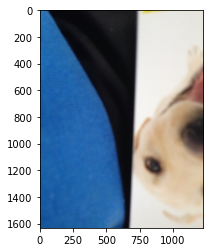

['a picture of a very nice smiling dog', 'some sort of animal is shown in a white space next to a blue object', 'a picture of a smiling dog that seems to be a yellow lab', 'part of a picture of a white dog']
Predicted caption: a person is holding a black and white object


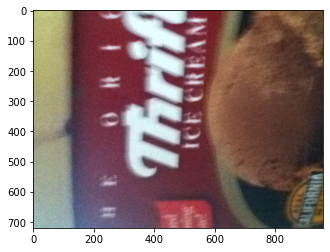

['package for ice cream that shows image of the product on the cover', 'a box of thrifty ice cream has chocolate ice cream on it', 'a box of chocolate ice cream sitting on a white tile surface', 'a picture of an ice cream can with a chocolate ball on the outside']
Predicted caption: a bottle containing a bottle of some sort of food product


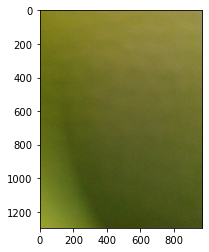

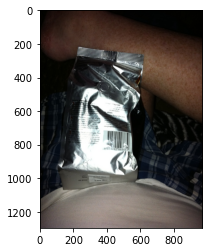

['the back of a silver pouch of coffee grounds showing the ingredients and instructions', 'a packed food which is ready to eat', 'a person holds a silver package of vacuum sealed coffee grounds in their lap', 'a silver bag containing food of some kind is laying in a persons lap that is wearing a t shirt and shorts', 'a silver packet with a barcode laying on light brown surface']
Predicted caption: some sort of blanket that is red and white shirt


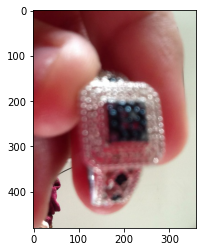

['someone is holding a ring in his hand', 'a close up of someone holding a ring with a square shaped dark colored diamond', 'a square ring with dark and white jewels its possibly costume jewelry', 'in this picture is a image of a ring', 'a silver ring with small diamonds and dark colored stones']
Predicted caption: image was clear but it is not half of the image is half


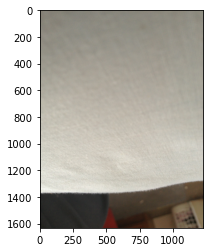

['maybe a bedspread or a pillow upside down with a smaller cylinder in the background next to a few other items', 'a white sheet on top of a bed']
Predicted caption: i see a food item on the table


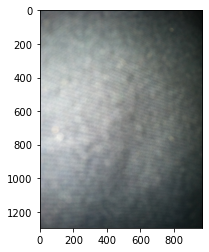

['a very close up shot of what i assume to be grey cotton fabric from an article of clothing', 'a close up of s denim jean article of clothing', 'close up of some gray fabric that is brightly lit', 'a blue section of denim fabric with horizontal grooves']
Predicted caption: appears to be a picture of a white fabric


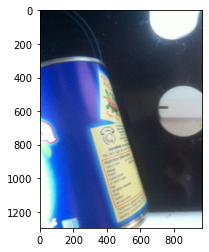

['a can with blue label showing the nutrition label', 'for dinner we will put our lives on the line and have this can of mystery meat', 'part of a nutrition label of a soup can', 'you have taken a picture of part of the nutritional label on a can of food', 'a blue can on top of a induction stove']
Predicted caption: a screen has a sticker for the middle and a


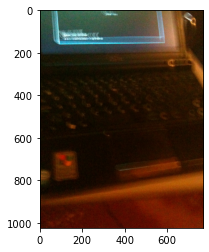

['the keyboard and bottom screen of a laptop', 'a black laptop with a dark screen except the outline of a blue box', 'a black laptop open with the screen turned on', 'a laptop computer with a screen that displays a pop up', 'an open laptop showing something on the screen']
Predicted caption: a computer monitor is on top of a wood surface


In [ ]:
for i in range(9):
    try:
        pic = 'VizWiz_train_0000209%d'%(i)
        x = plt.imread('dataset/validation/' + pic + '.jpg')
        plt.imshow(x)
        plt.show()
        print(val_descriptions[pic])
        print("Predicted caption:",results[pic][0])
    except:
        pass